# Indoor Positioning System

## Pré-processamento
Aqui será conhecida a base de dados, se existem linhas repetidas, valores ausentes e tratamento de *outliers*.

In [1]:
%matplotlib inline
import matplotlib
import random
import warnings
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from scipy.stats import norm, normaltest, mode
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import BallTree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
import ipywidgets as widgets
from ipywidgets import interact_manual, IntSlider
matplotlib.rc('xtick', labelsize=14)
matplotlib.rc('ytick', labelsize=14)

In [2]:
# Extrai dados de um txt pelo numpy
dadosRot = np.loadtxt('wifi_localization.txt', delimiter='\t')
print(dadosRot.shape)

(2000, 8)


In [3]:
'''
Separa entre conjunto de dados e conjunto de rótulos. Além de criar um Panel Data com nomes como: nome do índice
para Medição, criar as colunas Intensidade do Roteador X (IntRotX) e mudar os rótulos da Sala(0~3). 
'''

x = pd.DataFrame(dadosRot[:,0:7], dtype='float64', columns=['IntRot1','IntRot2','IntRot3',
                                           'IntRot4','IntRot5','IntRot6','IntRot7'])

y = pd.Series(dadosRot[:,7]-1, dtype='uint8', name='Sala') # Salas com rótulos: y={0,1,2,3}
med = pd.Series(np.arange(2000), name='Medição')
dados = pd.DataFrame(x,index=med)
dados = dados.join(y)
dados.head()

,IntRot1,IntRot2,IntRot3,IntRot4,IntRot5,IntRot6,IntRot7,Sala
Medição,,,,,,,,
0,-64.0,-56.0,-61.0,-66.0,-71.0,-82.0,-81.0,0
1,-68.0,-57.0,-61.0,-65.0,-71.0,-85.0,-85.0,0
2,-63.0,-60.0,-60.0,-67.0,-76.0,-85.0,-84.0,0
3,-61.0,-60.0,-68.0,-62.0,-77.0,-90.0,-80.0,0
4,-63.0,-65.0,-60.0,-63.0,-77.0,-81.0,-87.0,0


In [4]:
# Verifica se existem valores nulos, mostra número, nome de colunas e tipos de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IntRot1  2000 non-null   float64
 1   IntRot2  2000 non-null   float64
 2   IntRot3  2000 non-null   float64
 3   IntRot4  2000 non-null   float64
 4   IntRot5  2000 non-null   float64
 5   IntRot6  2000 non-null   float64
 6   IntRot7  2000 non-null   float64
 7   Sala     2000 non-null   uint8  
dtypes: float64(7), uint8(1)
memory usage: 207.0 KB


In [5]:
# Analisa quantidade de instâncias (medições) por classe (sala)
print('Sala 0: ', sum(dados.loc[:,'Sala']==0))
print('Sala 1: ', sum(dados.loc[:,'Sala']==1))
print('Sala 2: ', sum(dados.loc[:,'Sala']==2))
print('Sala 3: ', sum(dados.loc[:,'Sala']==3))

Sala 0:  500
Sala 1:  500
Sala 2:  500
Sala 3:  500


In [6]:
# Verifica se existem linhas de medições idênticas por classe
dup = sum(dados.duplicated())
print('Quantidade de linhas duplicadas por atributos e classes: ' + str(dup))

# Verifica se existem linhas de medições idênticas apenas entre os atributos
dup = sum(dados.drop(columns='Sala').duplicated())
print('Quantidade de linhas duplicadas apenas por atributos: ' + str(dup))

Quantidade de linhas duplicadas por atributos e classes: 0
Quantidade de linhas duplicadas apenas por atributos: 0


In [7]:
# Análise estatística de cada atributo para cada classe e retorna os índices dos outliers (fora dos limites)
def analise_outliers():
    tot_out = set([])
    for i in range(1,8):
        for j in range(0,4):
            atr = 'IntRot'+str(i)
            part = dados.loc[(dados.loc[:,'Sala'])==j, atr]
            est1 = part.describe()
            mnm = est1.loc['mean']-3*est1.loc['std']
            mxm = est1.loc['mean']+3*est1.loc['std']
            tot_out = tot_out.union(set((part.loc[(np.array(part.loc[:] >= mxm) |\
                                                   np.array(part.loc[:] <= mnm))]).index))
    print("Os índices dos outliers são: ",tot_out)
    tot_out = np.array(list(tot_out))
    print("\nPerdas de instâncias por classe:\n")
    print(sum(tot_out<=499))
    print(sum((tot_out>=500) & (tot_out<=999)))
    print(sum((tot_out>=1000) & (tot_out<=1499)))
    print(sum(tot_out>=1499))
    return set(tot_out)

In [8]:
# Normalizar conjunto de dados
def normalizador(d):
    rotulos = np.array(d.iloc[:,-1])
    scaler = StandardScaler()
    norm_dados = scaler.fit_transform(d.iloc[:,0:-1])
    norm_dados = pd.DataFrame(norm_dados)
    norm_dados = norm_dados.join(pd.Series(rotulos, name='Sala',dtype='uint8'))
    return norm_dados

In [9]:
# Isolation Forest aplicada a todos atributos
def isolation_forest():
    ind = set([])
    clf = IsolationForest(max_samples=500, random_state = 1, contamination='auto', max_features=7)
    for i in range(0,4):
        preds = -0.5*((clf.fit_predict(dados.iloc[np.array(dados.loc[:,'Sala']==i),0:7])-1))
        ind = ind.union(set(np.array(np.where(preds==1))[0]+500*i))
    ind = np.array(list(ind))
    print(ind)
    print(np.sum((ind)<=499))
    print(np.sum((ind>=500) & (ind<=999)))
    print(np.sum((ind>=1000) & (ind<=1499)))
    print(np.sum(ind>=1500))
    return set(ind)

In [10]:
# Retirar os outliers do dataframe 'dados'
#outliers = analise_outliers()
outliers = isolation_forest()
val_proc = np.sort(np.array(list(set(np.arange(0,2000))-outliers)))
print("\nQuantidade das instâncias que serão utilizadas: ", len(val_proc))
dados_proc = dados.iloc[val_proc]

[1630  527 1041  530  531  532  536   25  537  539  540  541 1566 1567
 1568   37   38 1579 1071 1584   49 1073 1586   52   53  566 1078 1587
 1602 1603  581 1098 1102 1615  597   87   88   89   90   91   92   93
   94   95  604   97   98   99  100  605  607  608  609  618  624  625
  114 1649  628 1650  119  637  638 1663  132  133  138  650  652 1680
  657  660 1685  666  158  168  176 1204 1207 1209 1726 1727 1217  710
 1222 1737  202 1227 1237 1752 1242 1243 1756 1245 1246 1757 1758 1759
 1252  233 1778 1271  254  255  768  769 1281 1791 1790  773  777  778
 1290  780  781 1292 1826  317  829  319 1863 1866 1874  339 1877  858
  859  862 1888  867 1892  869  873 1900 1391 1910  379 1403  414  928
  930 1453 1974  956  452 1989 1483  463  975  984  603 1499 1502  995
 1624 1515  496  499 1013 1014 1015 1626]
40
50
30
42

Quantidade das instâncias que serão utilizadas:  1838


## Análise e exploração dos dados
Aqui serão feitas hipóteses, além de selecionar as features por PCA.

In [11]:
# Análise da distribuição por atributo dada classe sem outliers, e ajustando uma gaussiana para cada distribuição
# Aplica o teste de D’Agostino K^2 nas amostras para observar se seguem a distribuição normal
@interact_manual(roteador=IntSlider(1,1,7), sala=IntSlider(0,0,3))
def dist_atr(roteador, sala):
    atr = 'IntRot'+str(roteador)
    part = dados_proc.loc[(dados_proc.loc[:,'Sala'])==sala, atr]
    est2 = part.describe()
    print(est2)
    media = est2['mean']
    des_pad = est2['std']
    
    # Teste de normalidade
    stat, p = normaltest(np.array(part.loc[:]))
    print('stat=%.3f, p=%.3f' % (stat, p))
    if p > 0.01:
        print("Provavelmente Gaussiana")
    else:
        print("Provavelmente Não Gaussiana")
    
    # Plot do histograma dos dados
    plt.hist(dados_proc.loc[dados_proc.loc[:,'Sala']==sala, atr], density=True, bins=8)
    
    # Ajustando distribuição
    eixo_x = np.linspace(media-3.5*des_pad, media+3.5*des_pad, 1000)
    plt.plot(eixo_x, norm.pdf(eixo_x, media, des_pad), 'r', lw=2)
    plt.grid()
    plt.xlabel('Intensidade do sinal (dBmW)', fontsize=14)
    plt.ylabel('Densidade', fontsize=14)
    plt.show()
    return

interactive(children=(IntSlider(value=1, description='roteador', max=7, min=1), IntSlider(value=0, description…

In [12]:
# Gera matriz de covariância dos dados para 
# Análise de Componentes Principais (PCA) a fim de eliminar alguns atributos

Sigma = np.cov(np.array(dados_proc.iloc[:,0:7]), rowvar=0, bias=1)
print("Matriz de Covariância:\n",Sigma,"\n")

# Matriz de Correlação 
Corr = dados_proc.iloc[:,0:7].corr()
print("Matriz de Correlação:\n",Corr,"\n")

# Ordenar variâncias por atributos ordem crescente
var_atr = np.sort(np.array(Sigma).diagonal())
print("Variâncias: ",var_atr,"\n")

# Ordenar autovalores ordem crescente
var_eig = np.sort(np.linalg.eigvalsh(np.array(Sigma)))
print("Autovalores: ",var_eig)

Matriz de Covariância:
 [[108.78654029   0.90388261   5.63126169 101.9767169  -22.43402105
   48.86267392  47.05068136]
 [  0.90388261   9.66953246   4.09391092   1.44971234   4.5643352
    1.36702737   0.81585108]
 [  5.63126169   4.09391092  26.45323073   7.0855474   27.66982728
   -3.07768237  -2.29301732]
 [101.9767169    1.44971234   7.0855474  113.29644395 -21.25838749
   48.64459346  46.83595856]
 [-22.43402105   4.5643352   27.66982728 -21.25838749  77.56353449
  -24.77796838 -21.18170564]
 [ 48.86267392   1.36702737  -3.07768237  48.64459346 -24.77796838
   40.75813618  30.07361576]
 [ 47.05068136   0.81585108  -2.29301732  46.83595856 -21.18170564
   30.07361576  40.85720866]] 

Matriz de Correlação:
           IntRot1   IntRot2   IntRot3   IntRot4   IntRot5   IntRot6   IntRot7
IntRot1  1.000000  0.027869  0.104973  0.918555 -0.244225  0.733808  0.705739
IntRot2  0.027869  1.000000  0.255974  0.043800  0.166666  0.068860  0.041046
IntRot3  0.104973  0.255974  1.000000  0.1294

Fração de perda da variância por atributo:  [1.         0.72855626 0.46791767 0.2820854  0.18419677 0.0865455
 0.02316696]
Fração de perda da variância por dimensão do PCA:  [1.         0.35200729 0.1424535  0.09655173 0.06561088 0.04067933
 0.01917844]


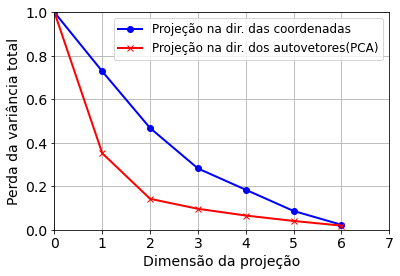

In [13]:
# Método PCA comparado ao da seleção de atributos

# Perda residual de variância por coordenadas
total_var_atr = np.cumsum(var_atr)
total_var_atr = total_var_atr / total_var_atr[6]
print("Fração de perda da variância por atributo: ", total_var_atr[6::-1])

# Perda residual de variância na direção dos autovetores
total_var_eig = np.cumsum(var_eig)
total_var_eig = total_var_eig / total_var_eig[6]
print("Fração de perda da variância por dimensão do PCA: ", total_var_eig[6::-1])

# Plot da variação residual
plt.plot(np.arange(0, 7), total_var_atr[6::-1], lw=2, ls='-', c='b', marker='o')
plt.plot(np.arange(0, 7), total_var_eig[6::-1], lw=2, ls='-', c='r', marker='x')
plt.xlabel('Dimensão da projeção', fontsize=14)
plt.ylabel('Perda da variância total', fontsize=14)
plt.legend(['Projeção na dir. das coordenadas', 'Projeção na dir. dos autovetores(PCA)'], fontsize=12)
plt.xlim(0, 7)
plt.ylim(0, 1.0)
plt.grid()
plt.show()

In [14]:
# Matriz de transformação do PCA de 7 dimensões para 2 dimensões (26.56% de perda da variância)

# Matriz de projeção do PCA
top = 2
aut_val, aut_vet = np.linalg.eigh(Sigma)
print("Matriz de autovetores:\n",aut_vet,'\n')
U = aut_vet[:,7-top::] # Selecionando as direções que resultaram nos maiores autovalores
print(U.shape)

Matriz de autovetores:
 [[-2.78275363e-01  6.67826900e-01 -6.67795883e-02 -1.28878139e-01
   2.30529532e-01  1.80122330e-01 -6.08204774e-01]
 [-8.58048696e-01 -2.57880772e-01 -1.49962906e-01  3.57447643e-01
  -2.03138183e-01  7.55454902e-02 -4.47308380e-03]
 [ 2.70629486e-01  2.16246183e-01  2.96956139e-01  7.64646324e-01
  -1.29059081e-01  4.36432831e-01 -6.77296948e-04]
 [ 1.41080054e-01 -6.59399839e-01  8.90059216e-02  3.56267275e-02
   3.31041930e-01  2.13195346e-01 -6.17297284e-01]
 [-2.73656780e-03 -6.91460323e-02 -1.92029911e-01 -4.15244128e-01
  -1.81624328e-01  8.40765272e-01  2.14556579e-01]
 [ 3.02457317e-01 -8.16788018e-03 -7.18668323e-01  1.54149209e-01
  -5.00310394e-01 -1.13037884e-01 -3.24220089e-01]
 [-4.10297416e-02 -3.29589276e-02  5.68847050e-01 -2.71069509e-01
  -7.04306837e-01 -7.91147766e-02 -3.12821605e-01]] 

(7, 2)


In [15]:
# Matriz de dados transformados
dim = U.shape[1]
cols = list([])
for i in range(1,dim+1):
    cols = np.append(cols, ['CP'+str(i)])
dados_proc_pca = np.dot(np.array(dados_proc.iloc[:,0:7]),U)
dados_proc_pca = pd.DataFrame(dados_proc_pca, dtype='float64',\
                              columns=cols).join(pd.Series(np.array(dados_proc.iloc[:,7]), dtype='uint8', name='Sala'))
print(dados_proc_pca.head())
print(dados_proc_pca.tail())
print(dados_proc_pca.describe())

          CP1         CP2  Sala
0 -100.468603  116.649614     0
1 -100.395870  120.693556     0
2 -103.994793  117.514264     0
3 -106.652070  113.372044     0
4 -104.575312  114.494468     0
            CP1         CP2  Sala
1833 -74.984287  123.482454     3
1834 -72.458860  120.717804     3
1835 -70.596417  124.208490     3
1836 -68.821857  122.631313     3
1837 -67.839808  119.267853     3
               CP1          CP2         Sala
count  1838.000000  1838.000000  1838.000000
mean    -85.908217   103.805292     1.503808
std       9.354793    16.450210     1.117845
min    -112.201454    48.650275     0.000000
25%     -93.158928    93.909091     0.250000
50%     -84.520946   107.165728     2.000000
75%     -79.081697   116.981095     2.000000
max     -62.421785   131.022810     3.000000


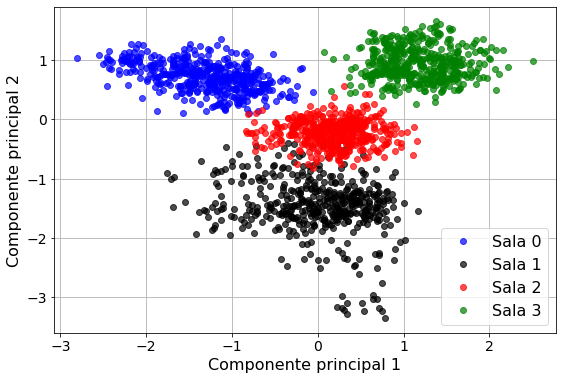

In [16]:
# Visualizar gráfico de dispersão para dados processados e após o pca retirar 5 componentes principais de 
# menor influência

norm = normalizador(dados_proc_pca)
marc = ['bo', 'ko', 'ro', 'go']
m_azul = mlines.Line2D([], [], color='blue', marker='o', label='Sala 0', alpha=0.7, linestyle='None')
m_pret = mlines.Line2D([], [], color='black', marker='o', label='Sala 1', alpha=0.7, linestyle='None')
m_verm = mlines.Line2D([], [], color='red', marker='o', label='Sala 2', alpha=0.7, linestyle='None')
m_verd = mlines.Line2D([], [], color='green', marker='o', label='Sala 3', alpha=0.7, linestyle='None')
plt.figure(figsize=(9,6))
plt.grid()
plt.xlabel('Componente principal 1', fontsize=16)
plt.ylabel('Componente principal 2', fontsize=16)
for i in range(norm.shape[0]):
    plt.plot(norm.iloc[i,0], norm.iloc[i,1], marc[norm.iloc[i,2]], alpha=0.7)
plt.legend(handles=[m_azul,m_pret,m_verm,m_verd], loc='lower right', fontsize=16);

In [17]:
# Transformar dados por PCA
def pca_trnsf(dtreino, dteste, topk_pca, metodo='outro', rtreino=0, rteste=0):
    if (metodo == 'knn'):
        rtreino = np.array(dtreino.iloc[:,-1])
        rteste = np.array(dteste.iloc[:,-1])
        dtreino = dtreino.drop('Sala', axis=1)
        dteste = dteste.drop('Sala', axis=1)
        Sigma = np.cov(np.array(dtreino), bias=1, rowvar=0)
        aut_val, aut_vet = np.linalg.eigh(Sigma)
        U = aut_vet[:,7-topk_pca::]
        dtreino = np.dot(np.array(dtreino), U)
        dteste = np.dot(np.array(dteste), U)
        dtreino = pd.DataFrame(dtreino).join(pd.Series(rtreino, name='Sala', dtype='uint8'))
        dteste = pd.DataFrame(dteste).join(pd.Series(rteste, name='Sala', dtype='uint8'))
        return dtreino, dteste
    else:
        scaler = StandardScaler()
        Sigma = np.cov(np.array(dtreino), bias=1, rowvar=0)
        aut_val, aut_vet = np.linalg.eigh(Sigma)
        U = aut_vet[:,7-topk_pca::]
        dtn = np.dot(np.array(dtreino), U)
        dts = np.dot(np.array(dteste), U)
        dtreino = scaler.fit_transform(dtn)
        dteste = scaler.fit_transform(dts)
        dtreino = pd.DataFrame(dtreino)
        dteste = pd.DataFrame(dteste)
        return dtreino, rtreino, dteste, rteste        

## Algorítmos de Aprendizado de Máquina
Aqui serão aplicados os seguintes algoritmos: 
* k Vizinhos Próximos (K-NN)
* Naive-Bayes
* Árvores de decisão
* SVM Linear
* Kernel SVM Multiclasse (RBF)

Serão obtidos para cada um dos método e para cada grupo de dados (com outliers, sem outliers, sem outliers PCA) erros e serão exibidos os índices de desempenho **APENAS** para aqueles que obtiveram os melhores resultados. Os classificadores serão validados por validação cruzada.

### Função de Hold out

In [26]:
# Hold out para gerar matriz de confusão, analisar índices de desempenho e plotar se topk_pca = 2 
def hold_out(cdados, frac_split, metodo='knn', topk_pca=0): 
    inst = cdados.shape[0]
    cols = cdados.shape[1]-1
    random.seed(0)
    ind_test = np.sort(random.sample(range(inst), int(frac_split*inst)))
    ind_trn = np.setdiff1d(np.arange(0,inst), ind_test)
    teste = cdados.iloc[ind_test,:]
    treino = cdados.iloc[ind_trn,:]
    dtrn = np.array(treino.iloc[:, 0:cols])
    rtrn = np.array(treino.iloc[:, cols])
    dtst = np.array(teste.iloc[:, 0:cols])
    rtst = np.array(teste.iloc[:, cols])
    
    if (metodo == 'knn'):
        prectn, prects, CM = k_NN(NN=9, ctreino=treino, cteste=teste, topk_pca=topk_pca, hout=True)
    elif (metodo == 'naive'):
        prectn, prects, CM = naive_bayes(dtrn, rtrn, dtst, rtst, topk_pca=topk_pca, hout=True)
    elif (metodo == 'arvore'):
        prectn, prects, CM = arv_dec(dtrn, rtrn, dtst, rtst, topk_pca=topk_pca, hout=True)
    elif (metodo == 'svm'):
        prectn, prects, CM = lin_svm(dtrn, rtrn, dtst, rtst, topk_pca=topk_pca, hout=True)
    elif (metodo == 'ksvm'):
        prectn, prects, CM = krn_svm(dtrn, rtrn, dtst, rtst, topk_pca=topk_pca, hout=True)
    else:
        print('Erro: Método não reconhecido')
        return
    
    ams, rev, pre, f1 = np.zeros(4), np.zeros(4), np.zeros(4), np.zeros(4) 
    print("Acurácia no treino: %.5f" % prectn)
    print("Acurácia no teste: %.5f" % prects)
    print("\nMatriz de Confusão:\n(i-> classe real)(j-> classe predita)\n\n", CM)
    print("\nMétricas de avaliação do modelo:\n")
    for i in range(0,4):
        ams[i] = int(CM[i,0]+CM[i,1]+CM[i,2]+CM[i,3])
        rev[i] = round(CM[i,i]/ams[i],3)                            # revocação -> qual é a proporção de acertos dentre os REAIS para a classe X
        pre[i] = round(CM[i,i]/(CM[0,i]+CM[1,i]+CM[2,i]+CM[3,i]),3) # precisão->qual é a proporção de acertos dentre os PREDITOS para a classe X
        f1[i] = round(2*(rev[i]*pre[i])/(rev[i]+pre[i]),3)          # F1-score-> média harmônica entre revocação e precisão, nem sempre é a melhor solução (depende do dom. de prob.)
    metricas = {"Precisão": pre, "Revocação": rev, "F1 Score": f1, "Num. Amostras": ams}
    metricas = pd.DataFrame(metricas, index=['Sala 0', 'Sala 1', 'Sala 2', 'Sala 3'])
    print(metricas)
    return

### K Vizinhos Próximos

In [19]:
# Implementa o algoritmo de K Vizinhos Próximos e retorna a precisão
def k_NN(NN, ctreino, cteste, topk_pca, hout=False):

    cols=7
    if(topk_pca):
        ctreino, cteste = pca_trnsf(ctreino, cteste, topk_pca, metodo='knn')
        ctreino = normalizador(ctreino)
        cteste = normalizador(cteste)
        cols = topk_pca
    
    balltree = BallTree(ctreino.iloc[:,0:cols])
    ind_NNts = np.squeeze(balltree.query(cteste.iloc[:,0:cols], k=NN, return_distance=False))
    ind_NNtn = np.squeeze(balltree.query(ctreino.iloc[:,0:cols], k=NN, return_distance=False))
    n_test = len(ind_NNts)
    n_trn = len(ind_NNtn)
    ind_NNts = np.reshape(ind_NNts, (-1,NN))
    ind_NNtn = np.reshape(ind_NNtn, (-1,NN))
    cls_predts = np.zeros(n_test)
    cls_predtn = np.zeros(n_trn)

    for i in range(n_test):
        temp = np.zeros(NN)
        for j in range(NN):
            temp[j] = np.array(ctreino.iloc[ind_NNts[i,j],ctreino.shape[1]-1])
        cls_predts[i] = mode(temp)[0][0]
 
    for i in range(n_trn):
        temp = np.zeros(NN)
        for j in range(NN):
            temp[j] = np.array(ctreino.iloc[ind_NNtn[i,j],ctreino.shape[1]-1])
        cls_predtn[i] = mode(temp)[0][0]

    cls_realts = np.array(cteste.iloc[:,cteste.shape[1]-1])
    acertosts = cls_predts == cls_realts
 
    cls_realtn = np.array(ctreino.iloc[:,ctreino.shape[1]-1])
    acertostn = cls_predtn == cls_realtn
    
    prects = float(sum(acertosts))/float(len(cls_realts))
    prectn = float(sum(acertostn))/float(len(cls_realtn))
 
    if (hout == True):
        flag='n'
        CM = confusion_matrix(cls_realts, cls_predts)
        if (topk_pca == 2):
            flag = input("Plotar resultado? s/n\n")
            print("\n")
        if (flag == 's'):
            graf_2d(cls=balltree, NN=NN, ctrn=ctreino, ctst=cteste, metodo='K Vizinhos Próximos')
        return prectn, prects, CM
    return prectn, prects

### Naïve Bayes

In [20]:
# Retorna a precisão do método Naive Bayes para base de treino e de teste (validação)
def naive_bayes(dtreino, rtreino, dteste, rteste, topk_pca, hout=False):
    
    if(topk_pca):
        dtreino, rtreino, dteste, rteste = pca_trnsf(dtreino, dteste, topk_pca, rtreino=rtreino, rteste=rteste)
    
    cls = GaussianNB()
    cls.fit(dtreino, rtreino)
    
    cls_predtn = cls.predict(dtreino)
    acertostn = cls_predtn == rtreino
    prectn = float(sum(acertostn))/float(len(rtreino))
    
    cls_predts = cls.predict(dteste)
    acertosts = cls_predts == rteste
    prects = float(sum(acertosts))/float(len(rteste))
    
    if (hout == True):
        flag='n'
        CM = confusion_matrix(rteste, cls_predts)
        if (topk_pca == 2):
            flag = input("Plotar resultado? s/n\n")
            print("\n")
        if (flag == 's'):
            graf_2d(cls, dtst=dteste, rtst=rteste, metodo='Naïve Bayes')
        return prectn, prects, CM
    return prectn, prects

### Árvore de decisão

In [21]:
# Retorna a precisão dos método Árvore de decisão
def arv_dec(dtreino, rtreino, dteste, rteste, topk_pca, hout=False):
    
    mf=7
    
    if(topk_pca):
        dtreino, rtreino, dteste, rteste = pca_trnsf(dtreino, dteste, topk_pca, rtreino=rtreino, rteste=rteste)
        mf = topk_pca
    
    cls = DecisionTreeClassifier()
    hparam = {"max_depth": [4], 
              "max_features": [5], 
              "criterion": ["gini"],
              "min_samples_leaf": [5]}
    grid_search = GridSearchCV(cls,hparam)
    
    grid_search.fit(dtreino,rtreino)
    best = grid_search.best_params_
    
    cls_predtn = grid_search.predict(dtreino)
    acertostn = cls_predtn == rtreino
    prectn = float(sum(acertostn))/float(len(rtreino))
    
    cls_predts = grid_search.predict(dteste)
    acertosts = cls_predts == rteste
    prects = float(sum(acertosts))/float(len(rteste))
    
    if (hout == True):
        flag='n'
        cls = DecisionTreeClassifier(criterion=best['criterion'], max_depth=best['max_depth'],\
                                     max_features=best['max_features'], min_samples_leaf=best['min_samples_leaf'])
        cls.fit(dtreino,rtreino)
        CM = confusion_matrix(rteste, cls_predts)
        plt.figure(figsize=(25,15))
        plot_tree(cls, fontsize=14)
        if (topk_pca == 2):
            flag = input("Plotar resultado? s/n\n")
        if (flag == 's'):
            graf_2d(cls, dtst=dteste, rtst=rteste, metodo='Árvore de Decisão')
        print("\nHiperparâmetros: ",best,"\n")
        return prectn, prects, CM
    print("\nHiperparâmetros: ",best,"\n")
    return prectn, prects

### SVM Linear

In [28]:
# Retorna precisão do método SVM linear
def lin_svm(dtreino, rtreino, dteste, rteste, topk_pca, hout=False):
    
    warnings.filterwarnings(action="ignore") # Problemas nas iterações
    
    if(topk_pca):
        dtreino, rtreino, dteste, rteste = pca_trnsf(dtreino, dteste, topk_pca, rtreino=rtreino, rteste=rteste)
    
    cls = LinearSVC(loss='hinge', multi_class='crammer_singer', max_iter=30000, dual=True)
    hparam = {"C":[2.5]}
    grid_search = GridSearchCV(cls, hparam)
    grid_search.fit(dtreino, rtreino)
    best = grid_search.best_params_
    
    cls_predtn = grid_search.predict(dtreino)
    acertostn = cls_predtn == rtreino
    prectn = float(sum(acertostn))/float(len(rtreino))
    
    cls_predts = grid_search.predict(dteste)
    acertosts = cls_predts == rteste
    prects = float(sum(acertosts))/float(len(rteste))

    if (hout == True):
        flag='n'
        CM = confusion_matrix(rteste, cls_predts)
        if (topk_pca == 2):
            flag = input("Plotar resultado? s/n\n")
        if (flag == 's'):
            cls = LinearSVC(loss='hinge', C=best['C'], multi_class='crammer_singer', max_iter=30000, dual=True)
            cls.fit(dtreino,rtreino)
            graf_2d(cls, dtst=dteste, rtst=rteste, metodo='SVM')
        print("\nHiperparâmetros: ",best,"\n")
        return prectn, prects, CM
    print("\nHiperparâmetros: ",best,"\n")
    return prectn, prects

### Kernel SVM

In [30]:
# Retorna precisão do método kernel SVM
def krn_svm(dtreino, rtreino, dteste, rteste, topk_pca, hout=False):
    
    if(topk_pca):
        dtreino, rtreino, dteste, rteste = pca_trnsf(dtreino, dteste, topk_pca, rtreino=rtreino, rteste=rteste)
    
    cls = SVC(kernel='rbf', max_iter=30000)
    hparam = {"C":[10], "gamma":[0.1]}
    grid_search = GridSearchCV(cls, hparam)
    grid_search.fit(dtreino, rtreino)
    best = grid_search.best_params_
    
    cls_predtn = grid_search.predict(dtreino)
    acertostn = cls_predtn == rtreino
    prectn = float(sum(acertostn))/float(len(rtreino))
    
    cls_predts = grid_search.predict(dteste)
    acertosts = cls_predts == rteste
    prects = float(sum(acertosts))/float(len(rteste))
       
    if (hout == True):
        flag='n'
        CM = confusion_matrix(rteste, cls_predts)
        if (topk_pca == 2):
            flag = input("Plotar resultado? s/n\n")
        if (flag == 's'):
            cls = SVC(kernel='rbf', gamma=best['gamma'], C=best['C'], max_iter=30000)
            cls.fit(dtreino,rtreino)
            graf_2d(cls, dtst=dteste, rtst=rteste, metodo='RBF Kernel SVM')
        print("\nHiperparâmetros: ",best,"\n")
        return prectn, prects, CM
    print("\nHiperparâmetros: ",best,"\n")
    return prectn, prects

### Função de Validação Cruzada
Está função é a mestre já que ela chamará todas as outra funções de aprendizado de máquina. Ela retornará a precisão média por validação cruzada por k-fold.

In [24]:
# Retorna precisão média por validação cruzada
def prec_mod_valx(cdados, kfold=5, metodo='knn', param=1, topk_pca=0):
    # Número de instâncias, atributos, vetor de precisões
    n_inst = cdados.shape[0]
    n_atr = cdados.shape[1]
    prec_tst = np.zeros(kfold)
    prec_trn = np.zeros(kfold)
    
    # Dividindo entre conjunto de dados e conjunto de rótulos 
    x = np.array(cdados.iloc[:,0:n_atr-1])
    y = np.array(cdados.iloc[:,n_atr-1])
    
    # Validação cruzada
    np.random.seed(None)
    ind = np.random.permutation(n_inst)
    for i in range(kfold):
        ind_val = ind[int(i*(n_inst/kfold)):int((i+1)*(n_inst/kfold)-1)]
        ind_trn = np.setdiff1d(ind, ind_val)
        
        if (metodo == 'knn'):
            rval = pd.Series(y[ind_val], name='Sala')
            cval = pd.DataFrame(x[ind_val,:]).join(rval)
            rtrn = pd.Series(y[ind_trn], name='Sala')
            ctrn = pd.DataFrame(x[ind_trn,:]).join(rtrn)
            prec_trn[i], prec_tst[i] = k_NN(param, ctrn, cval, topk_pca)
        elif (metodo == 'naive'):
            prec_trn[i], prec_tst[i] = naive_bayes(x[ind_trn], y[ind_trn], x[ind_val], y[ind_val], topk_pca)
        elif (metodo == 'arvore'):
            prec_trn[i], prec_tst[i] = arv_dec(x[ind_trn], y[ind_trn], x[ind_val], y[ind_val], topk_pca)
        elif (metodo == 'ksvm'):
            prec_trn[i], prec_tst[i] = krn_svm(x[ind_trn], y[ind_trn], x[ind_val], y[ind_val], topk_pca)
        elif (metodo == 'svm'):
            prec_trn[i], prec_tst[i] = lin_svm(x[ind_trn], y[ind_trn], x[ind_val], y[ind_val], topk_pca)
        else:
            print('Erro: Método não reconhecido')
            return
        
    prec_med_trn = float(sum(prec_trn))/float(kfold)
    prec_med_tst = float(sum(prec_tst))/float(kfold)
    print("Acurácia no treino: %.5f" % prec_med_trn)
    print("Acurácia no teste: %.5f" % prec_med_tst)
    return

In [1]:
# Função para plots com meshgrid
def graf_2d(cls=0, NN=0, ctrn=0, ctst=0, dtst=0, rtst=0, metodo='outro'):
    # Configurar gráfico
    # Plot das instâncias de teste
    
    colors = ["cornflowerblue", "gray", "lightcoral", "springgreen"]
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("meucmap", colors)
    
    cores = ['bo', 'ko', 'ro', 'go']
    
    plt.figure(figsize=(9,6))
    
    if (metodo == 'K Vizinhos Próximos'):
        x1min = min(ctst.iloc[:,0]) - 0.25
        x1max = max(ctst.iloc[:,0]) + 0.25
        x2min = min(ctst.iloc[:,1]) - 0.25
        x2max = max(ctst.iloc[:,1]) + 0.25
        plt.xlim(x1min,x1max)
        plt.ylim(x2min,x2max)
        for rot in range(4):
            x1 = np.array(ctst)[ctst.iloc[:,-1]==rot, 0]
            x2 = np.array(ctst)[ctst.iloc[:,-1]==rot, 1]
            plt.plot(x1, x2, cores[rot%4], alpha=0.9)
        grid_res = 0.025
        xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_res), np.arange(x2min, x2max, grid_res))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        balltree = BallTree(ctrn.iloc[:,0:2])
        ind_NNg = np.squeeze(balltree.query(grid, k=NN, return_distance=False))
        ng = len(ind_NNg)
        ind_NNg = np.reshape(ind_NNg, (-1,NN))
        Z = np.zeros(ng)
        
        for i in range(ng):
            temp = np.zeros(NN)
            for j in range(NN):
                temp[j] = np.array(ctrn.iloc[ind_NNg[i,j],ctrn.shape[1]-1])
            Z[i] = mode(temp)[0][0]
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=cmap1, vmin=0, vmax=3, shading='auto')
        plt.legend(['Sala 0', 'Sala 1', 'Sala 2', 'Sala 3'], loc='lower right', fontsize=16)
        plt.xlabel("Componente Principal 1", fontsize=16)
        plt.ylabel("Componente Principal 2", fontsize=16)
        plt.title("Método: "+metodo, fontsize=18)
        plt.show()
        return
    else:
        dtst = np.array(dtst)
        rtst = np.array(rtst)
        x1min = min(dtst[:, 0]) - 0.25
        x1max = max(dtst[:, 0]) + 0.25
        x2min = min(dtst[:, 1]) - 0.25
        x2max = max(dtst[:, 1]) + 0.25
        plt.xlim(x1min,x1max)
        plt.ylim(x2min,x2max)
        for rot in range(4):
            x1 = dtst[(rtst[:]==rot), 0]
            x2 = dtst[(rtst[:]==rot), 1]
            plt.plot(x1, x2, cores[rot%4], alpha=0.9)
        grid_res = 0.01
        xx1, xx2 = np.meshgrid(np.arange(x1min, x1max, grid_res), np.arange(x2min, x2max, grid_res))
        grid = np.c_[xx1.ravel(), xx2.ravel()]
        Z = cls.predict(grid)
        Z = Z.reshape(xx1.shape)
        plt.pcolormesh(xx1, xx2, Z, cmap=cmap1, vmin=0, vmax=3, shading='auto')
        plt.legend(['Sala 0', 'Sala 1', 'Sala 2', 'Sala 3'], loc='lower right', fontsize=16)
        plt.xlabel("Componente Principal 1", fontsize=16)
        plt.ylabel("Componente Principal 2", fontsize=16)
        plt.title("Método: "+metodo, fontsize=18)
        plt.show()
        return
    return

In [216]:
prec_mod_valx(dados_proc, metodo='ksvm', topk_pca=2, param=0)


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 

Acurácia no treino: 0.98559
Acurácia no teste: 0.98363


Plotar resultado? s/n
s


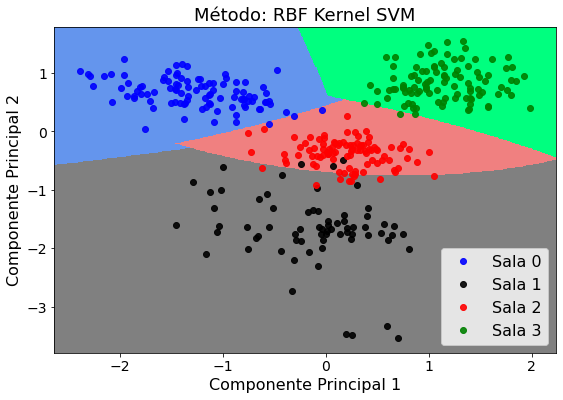


Hiperparâmetros:  {'C': 10, 'gamma': 0.1} 

Acurácia no treino: 0.98504
Acurácia no teste: 0.94823

Matriz de Confusão:
(i-> classe real)(j-> classe predita)

 [[ 97   0   3   0]
 [  0  66   3   0]
 [  0  11  85   0]
 [  0   0   2 100]]

Métricas de avaliação do modelo:

        Precisão  Revocação  F1 Score  Num. Amostras
Sala 0     1.000      0.970     0.985          100.0
Sala 1     0.857      0.957     0.904           69.0
Sala 2     0.914      0.885     0.899           96.0
Sala 3     1.000      0.980     0.990          102.0


In [31]:
hold_out(dados_proc, frac_split=0.2, metodo='ksvm', topk_pca=2)